# Project - Problem 1

Implementation of VO

## Import Modules

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

In [ ]:
%matplotlib inline
# load K and first two images
K = np.loadtxt('data/K.txt')
img0 = cv2.imread('data/img_00000.png', cv2.IMREAD_GRAYSCALE)

print('K=',K)
cv2_imshow(img0)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import scipy.spatial.distance
import importlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Extract mae6292.zip
with zipfile.ZipFile('/MAE6292.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MAE6292')

# Verify extraction

print("Extracted files:", os.listdir('/content/MAE6292'))

Extracted files: ['tools.py', '__init__.py', 'imshow.py']


In [ ]:
import sys
sys.path.append('/content/MAE6292')

In [ ]:
from MAE6292.imshow import cv2_imshow
import MAE6292.tools as mae6292

In [ ]:
K = np.loadtxt('/K.txt')
img0 = cv2.imread('/img_00000.png', cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/img_00001.png', cv2.IMREAD_GRAYSCALE)

print('K =', K)
cv2_imshow(img0)

In [ ]:
param_bootstrap = {
    'W_harris_patch': 4,
    'kappa_harris': 0.08,
    'N_keypoint': 2000,
    'W_nms': 8,
    'W_KLT': 4,
    'tol_KLT_bidir': 1,
    'tol_E': 1,
    'tol_E_RANSAC_prob': 0.99,
    'tol_TRI_mu': 1e-3,
    'tol_TRI_rep': 1
}

keypoints0, p_W0, R1, T1 = mae6292.VO_bootstrap(img0, img1, K, param_bootstrap, display=True)
print("Bootstrap complete with", len(keypoints0), "keypoints")

In [ ]:
import os
output_dir = "/content/drive/MyDrive/VO_outputs_test"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
param_mapping = {
    'W_harris_patch': 4,
    'kappa_harris': 0.08,
    'N_keypoint': 2000,
    'W_nms': 8,
    'W_KLT': 4,
    'tol_KLT_bidir': 1,
    'tol_TRI_mu': 1e-3,
    'tol_TRI_rep': 1,
    'tol_keypoints_new': 18
}

In [ ]:
img_pre = img0
S_pre = mae6292.state(keypoints0, p_W0, [np.zeros((3,1))])
C_pre = mae6292.candidate([],[],[],[])
N_frames = 199
T_W = np.zeros((3, N_frames + 1))
p_W = p_W0

for i_frame in range(2, N_frames + 1):
    print(f"Processing frame {i_frame:05d}...")

    img_path = f"/content/project-Prat1209/data/img_{i_frame:05d}.png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    R, T, S, C, fig = mae6292.VO_localization_mapping(
        i_frame, img, img_rgb, img_pre, S_pre, C_pre, K, param_mapping, display_process=True
    )

    img_pre, S_pre, C_pre = img, S, C
    T_W[:, i_frame] = (-R.T @ T).flatten()

    p_W_dist = scipy.spatial.distance.cdist(S.p_W.T, p_W.T, 'euclidean')
    index_distinct = np.where(np.min(p_W_dist, axis=1) > 3)[0]
    p_W = np.append(p_W, S.p_W[:, index_distinct], axis=1)

    fig.savefig(f"{output_dir}/frame_{i_frame:05d}.png")
    print(f"Saved: frame_{i_frame:05d}.png")

In [ ]:
np.savetxt(f"{output_dir}/trajectory.csv", T_W.T, delimiter=",", header="x,y,z", comments='')
print("Trajectory saved to:", f"{output_dir}/trajectory.csv")

Trajectory saved to: /content/drive/MyDrive/VO_outputs_test/trajectory.csv


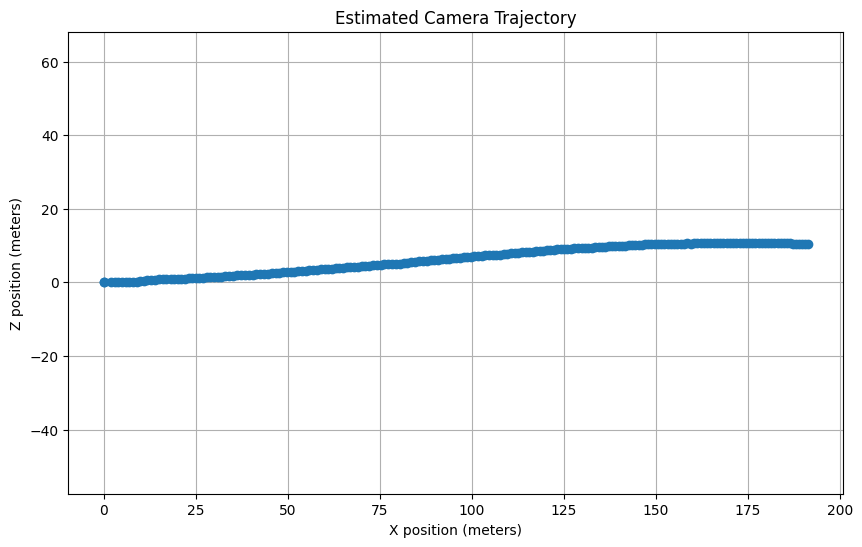

In [ ]:
import pandas as pd
traj = pd.read_csv("/content/drive/MyDrive/VO_outputs_test/trajectory.csv")

plt.figure(figsize=(10, 6))
plt.plot(traj["x"], traj["z"], marker='o', linestyle='-')
plt.xlabel("X position (meters)")
plt.ylabel("Z position (meters)")
plt.title("Estimated Camera Trajectory")
plt.grid(True)
plt.axis('equal')
plt.savefig("/content/drive/MyDrive/VO_outputs_test/trajectory_plot.png")
plt.show()

In [ ]:
!ffmpeg -framerate 5 -i "/content/drive/MyDrive/VO_outputs_test/frame_%05d.png" \
  -c:v libx264 -pix_fmt yuv420p /content/drive/MyDrive/VO_outputs_test/prob1.mp4
